In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.27'

## Downloading locally
- The easiest way to install diad fit is by removing the #, and running this once per computer. When I update the code, you'll need to get the new tag off GitHub:
https://github.com/PennyWieser/DiadFit/tags
Right click on the top one, over the 'zip' icon, click copy link address
- If youve already done this for Ne, you dont need to do here too

In [2]:
#!pip install --upgrade "https://github.com/PennyWieser/DiadFit/archive/refs/tags/v.0.26.zip"

In [3]:
pf.__version__

'0.0.27'

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!


In [4]:
# Add the path with your spectra in
mypath=r"G:\My Drive\Berkeley_NEW\DiadFit_outer\Testing\Error_Leilani\SPECTRA"

In [5]:
# This specifies what file type your Raman exported in. 
filetype='headless_txt'
# Specifying the extension here helps to filter out other file types,
# e.g. png files that may be in the folder
file_ext='.txt'
# If your instrument appends a nubmer like 01, 02 to each file, prefix=True removes it
prefix=False

## This function finds all files in your path with the specified file format
- As you will fit your Ne lines in a different workbook, you can use 'exclude_str' to put any text that appears in all your Ne files, and it won't look here

In [6]:
Diad_files=pf.get_files(path=mypath, file_ext=file_ext, exclude_str='Ne',
                            exclude_str_2='nodiad')
Diad_files

exclude type
.png


['LL4-FI1-#1.txt',
 'LL4-FI1-#2 (1).txt',
 'LL4-FI1-#2.txt',
 'LL7-107-FI#2_12mW1acc.txt',
 'LL7-107-FI#2_6mW.txt',
 'LL7-109-FI.txt',
 'LL7-FI33.txt',
 'LL7-FI34.txt',
 'LL8-433-FI_12mW.txt',
 'LL8-433-FI_6mW.txt']

## Select the first file you want to fit
- This allows you to tweak parameters for your spectra and your instrument

In [7]:
filename='LL7-109-FI.txt'#Diad_files[0] # This finds the first file

# Alternatively, you can specify the actual file name if you want to fit a specific one
#filename='007_k9.csv'
print(filename)

LL7-109-FI.txt


## First we plot the spectra
- This lets you look at the spectra, decide how strong your hotbands are, and see how elevated the diads are (if they are very elevated, you may need to fit a gaussian background too)

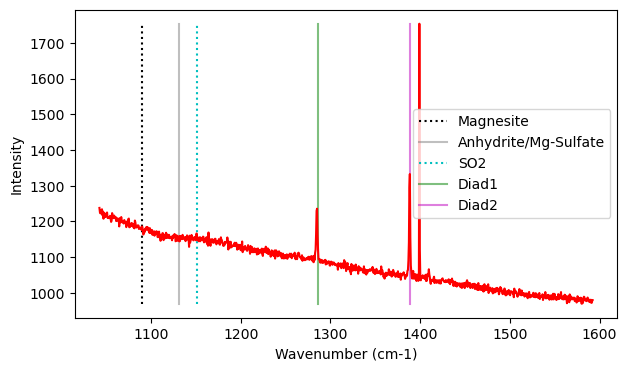

In [8]:
pf.plot_diad(path=mypath, filename=filename, filetype=filetype)

## After inspecting the spectra, decide if you want to fit the carbonate peak
- First, look at the presets, you can edit them in carb_peak_config by typing the variable name, and a new value

In [9]:
# Decide if you want to fit a carbonate peak or not here. 
fit_carbonate=False

# Tweak options here, can exclude a range for example using exclude_range=Tuple[float, float]
Carb_Config=pf.carb_peak_config(lower_bck=(1060, 1065), upper_bck=(1120, 1330))
Carb_Config   

carb_peak_config(lower_bck=(1060, 1065), upper_bck=(1120, 1330), N_poly_carb_bck=1, amplitude=1000, cent_carbonate=1090, outlier_sigma=12, N_peaks=3, distance=10, prominence=5, width=6, threshold=0.1, exclude_range=None, dpi=100, plot_figure=True, return_other_params=False)

## This actually does the work fitting the carbonate peak

In [10]:
Carb_fit=pf.fit_carbonate_peak(config=Carb_Config, path=mypath, 
filename=filename, filetype=filetype,
fit_carbonate=fit_carbonate)
Carb_fit

## Now lets plot the diads
- As with carbonate, you can exclude 2 segments (e.g. around cosmic rays)
- You then specify how many peaks you want to fit on each diad. 1 means just the strong peak, 2 hotbands, and 3 for Diad2 would also fit the C13 peak if present. 
- The identify_diad_peaks then uses scipy findpeaks to identify the positions of the 2 diads, and any other peaks the user asks for. These are saved, and fed into the later functions for peak fitting. 

In [11]:
diad_id_config=pf.diad_id_config(exclude_range1=[1396,1402])#exclude_range1=[1398,1405],prominence=50
diad_id_config

diad_id_config(exclude_range1=[1396, 1402], exclude_range2=None, approx_diad2_pos=(1379, 1395), approx_diad1_pos=(1275, 1295), height=400, distance=5, threshold=0.5, width=0.5, prominence=10, plot_figure=True)

Initial estimates: Diad1+HB=[1285.1], Diad2+HB=[1388.5]


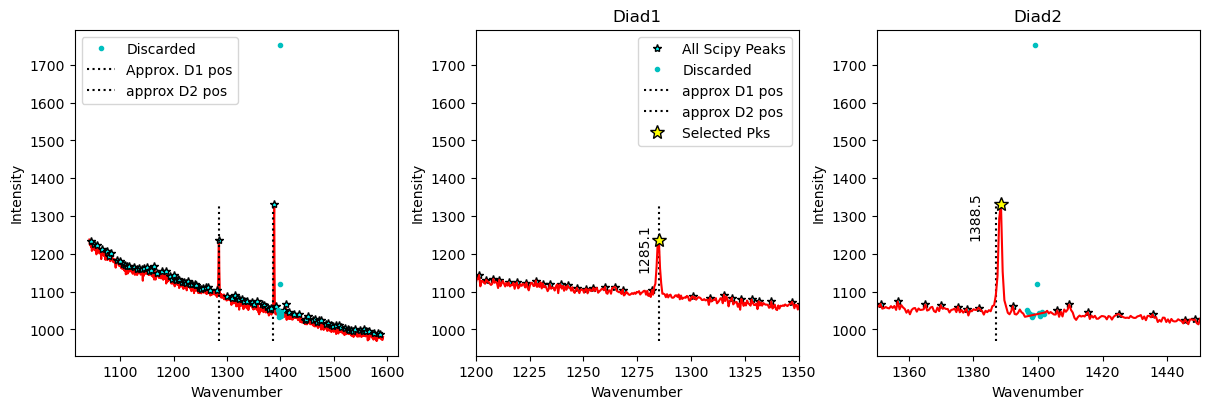

In [12]:
# Specify the number of peaks, 1 = just peak, 2 = Peak+hot bands
n_peaks_diad1=1
n_peaks_diad2=1 

    
diad1_peaks, diad2_peaks=pf.identify_diad_peaks(config=diad_id_config,
                        path=mypath, filename=filename,
filetype=filetype, n_peaks_diad1=n_peaks_diad1, n_peaks_diad2=n_peaks_diad2,
                                               block_print=False)

## If you have no diads visible...
- change True to False, and it will just save the carbonate peak parameters

In [17]:
diads_present=True
pf.proceed_to_fit_diads(filename, Carb_fit, diads_present=diads_present)

Move on to fit diads


## Fit Diad 1
- This function uses the guess of the peak parameters above. 
- For very dense diads, you may need to fit a gaussian background, defined by peak_pos_gauss=None, gauss_sigma=1, gauss_amp=3000
- Otherwise, the background is fitted with a polynomial you can set the degree for (Default =1) based on background positoins defined by lower_bck, upper_bck...
- If plot_figure=True, it saves the figure in its own folder in the path, so you can inspect all the fits at a later date. 

In [18]:
diad1_fit_config=pf.diad1_fit_config(peak_pos_gauss=None, 
                                     gauss_sigma=2,
                                     gauss_amp=200,
                                    lower_bck_diad1=(1200, 1230),
                                     upper_bck_diad1=(1320, 1350),
                                     x_range_residual=10, x_range_baseline=50,
                                    HB_amplitude=10, diad_amplitude=20,N_poly_bck_diad1=1)
diad1_fit_config

diad1_fit_config(peak_pos_gauss=None, gauss_sigma=2, gauss_amp=200, diad_sigma=0.2, N_poly_bck_diad1=1, lower_bck_diad1=(1200, 1230), upper_bck_diad1=(1320, 1350), diad_amplitude=20, HB_amplitude=10, x_range_baseline=50, y_range_baseline=100, plot_figure=True, dpi=200, x_range_residual=10, return_other_params=False)

,Diad1_Cent,Diad1_Area,Diad1_Sigma,Diad1_Gamma,Residual_Diad1
0,1284.829209,200.0,0.287766,0.287766,5.769124


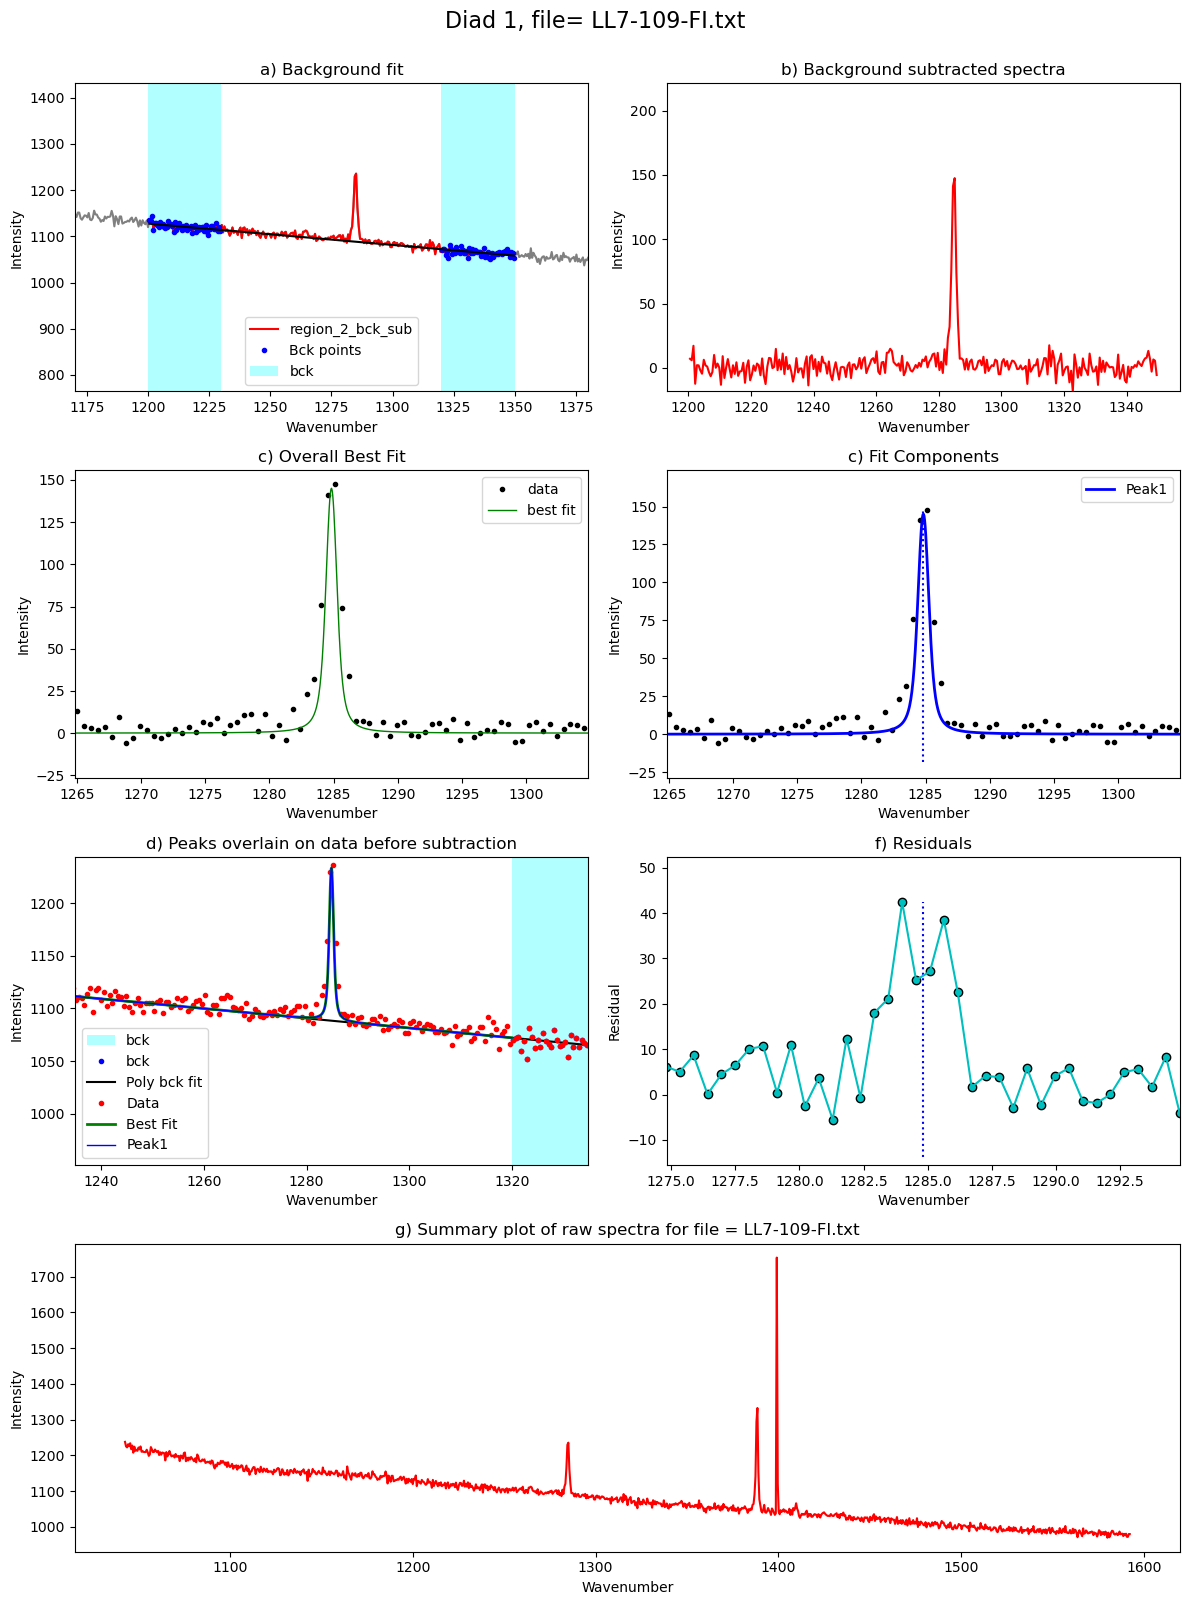

In [22]:
# For very dense spectra, with a very elevated background, you'll need to add a gaussian fit
# If you put a number in brackets, it'll center a gaussian extra background near there. 


# This function does the work fitting the diad
Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config,
    config2=diad_id_config, peak_pos_voigt=diad1_peaks,
path=mypath, filename=filename, filetype=filetype, close_figure=False)
Diad1_fit

## Fit diad 2

In [19]:
diad2_fit_config=pf.diad2_fit_config(x_range_residual=10, x_range_baseline=50,
                                     lower_bck_diad2=(1320, 1340),
                                     peak_pos_gauss=None, 
                                     gauss_sigma=3,
                                     gauss_amp=200,
                                   diad_amplitude=20,N_poly_bck_diad2=1  )
diad2_fit_config

diad2_fit_config(peak_pos_gauss=None, gauss_sigma=3, gauss_amp=200, diad_sigma=0.2, N_poly_bck_diad2=1, lower_bck_diad2=(1320, 1340), upper_bck_diad2=(1440, 1470), diad_amplitude=20, HB_amplitude=20, x_range_baseline=50, y_range_baseline=100, plot_figure=True, dpi=200, x_range_residual=10, return_other_params=False)

In [20]:
# Do you want to save the figure?
plot_figure=True
# This function does the work fitting the diad
Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config,
    config2=diad_id_config, peak_pos_voigt=diad2_peaks,
path=mypath, filename=filename, filetype=filetype)
Diad2_fit

,Diad2_Cent,Diad2_Area,Diad2_Sigma,Diad2_Gamma,Residual_Diad2
0,1388.293775,200.0,0.179565,0.179565,7.614653


## Combine and save
- Saves to clipboard if to_clipboard=True (e.g. you can paste into a spreadsheet)
- Also saves to 'csv' in a folder in "mypath" if to_csv=True)
- It also makes a new 

In [74]:
out=pf.combine_diad_outputs(filename=filename, prefix=prefix, 
Diad1_fit=Diad1_fit, to_clipboard=True, to_csv=True, path=mypath,
Diad2_fit=Diad2_fit, Carb_fit=Carb_fit)
out

,filename,Splitting,Diad1_Cent,Diad1_Area,Residual_Diad1,Diad2_Cent,Diad2_Area,Residual_Diad2,HB1_Cent,HB1_Area,HB2_Cent,HB2_Area,C13_Cent,C13_Area
0,LL7-109-FI,103.463792,1284.820331,332.569912,4.711408,1388.284123,498.756837,5.000364,NaN,0,NaN,0,NaN,0


## You can also try looping if all your spectra are pretty similar

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.06s/it]


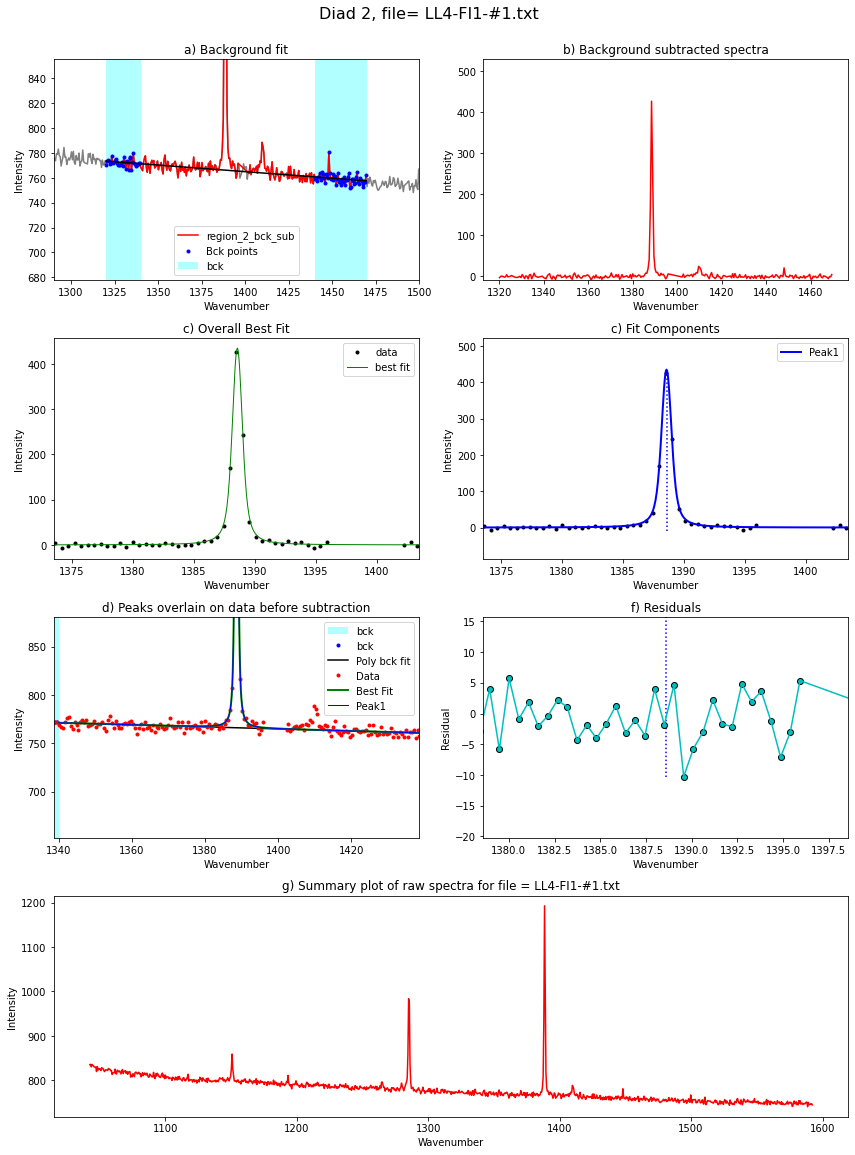

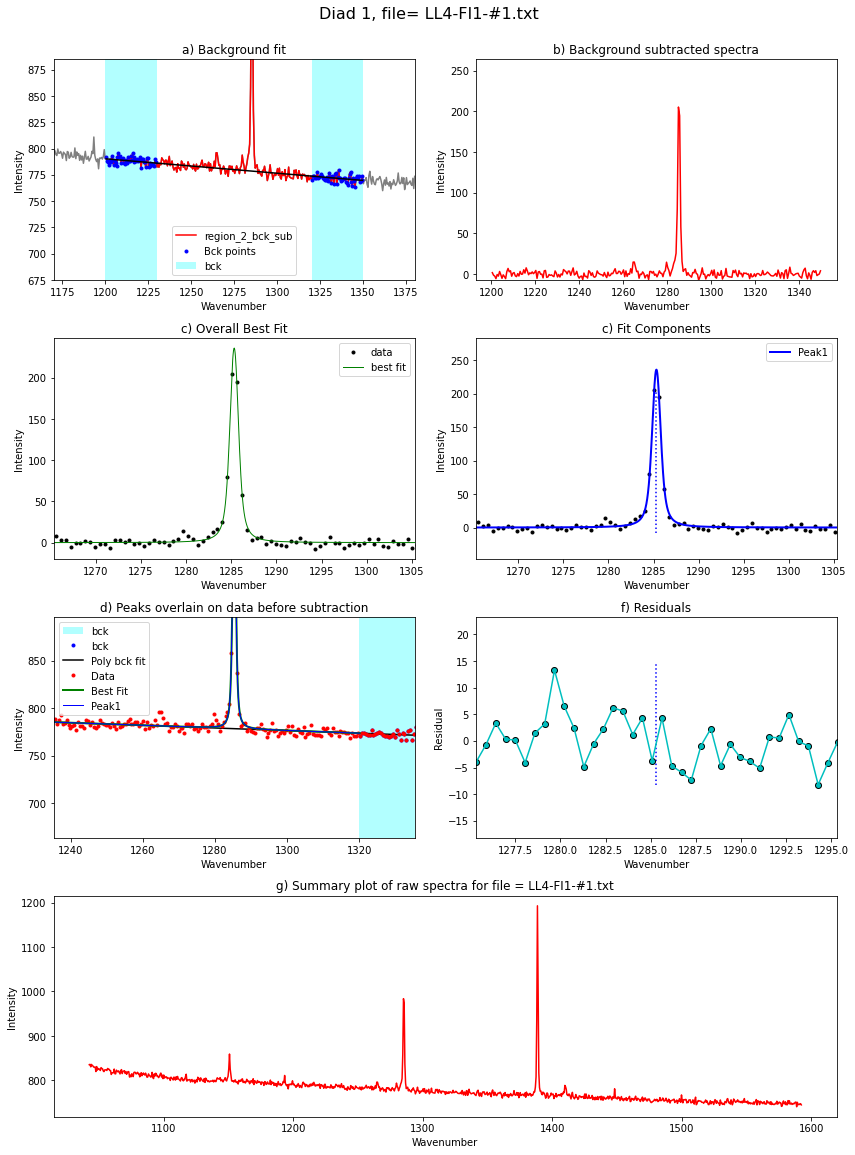

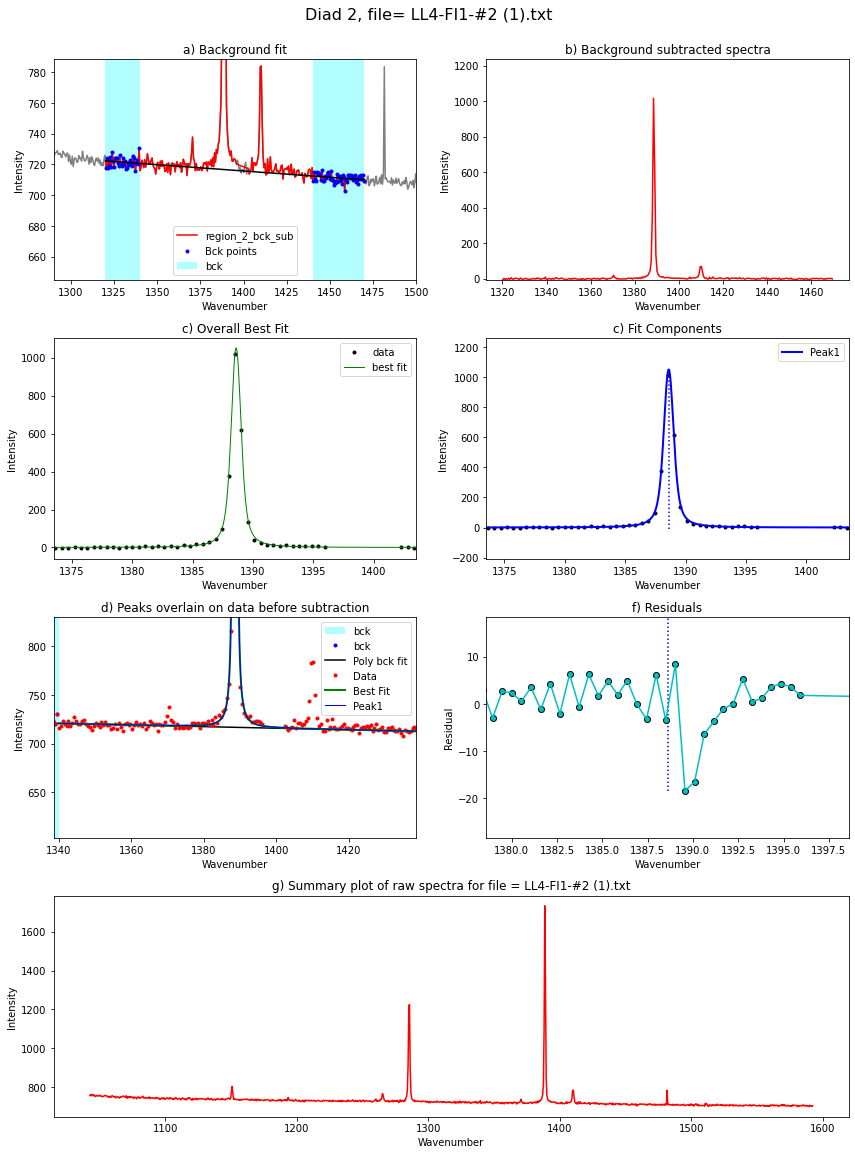

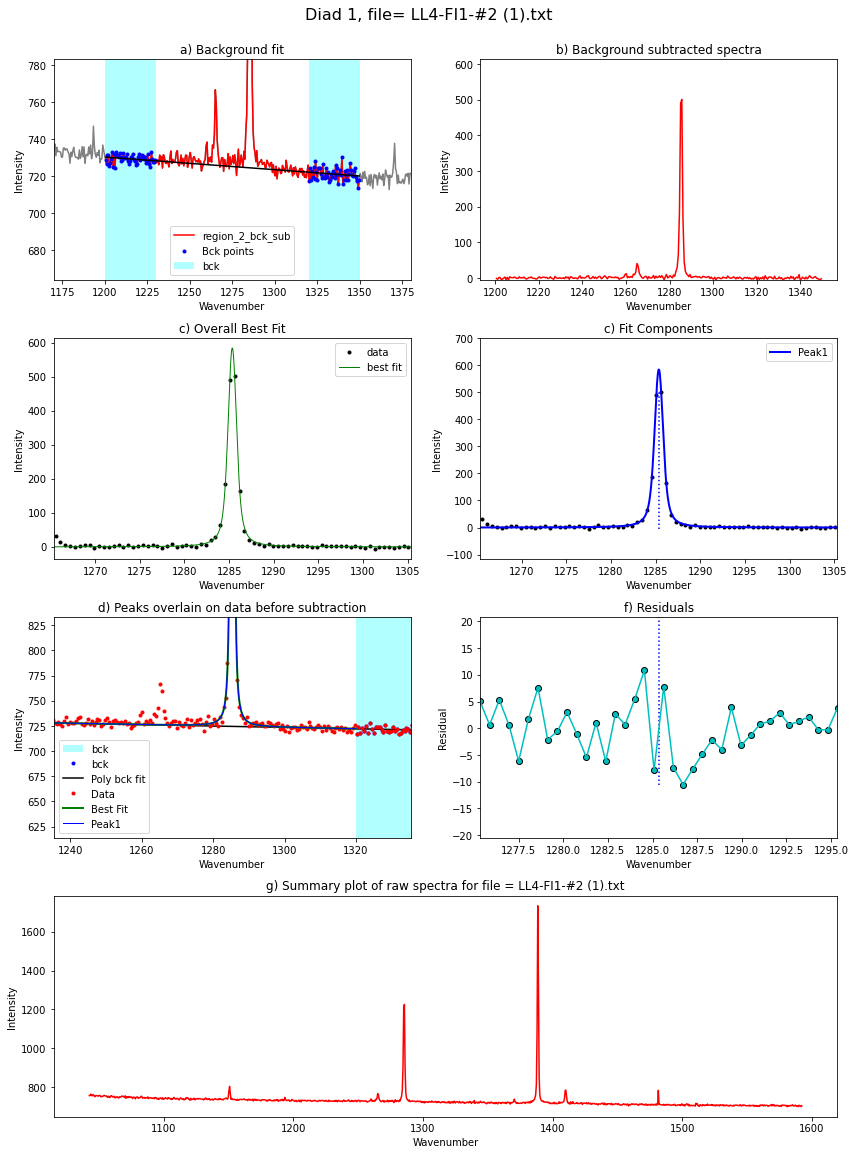

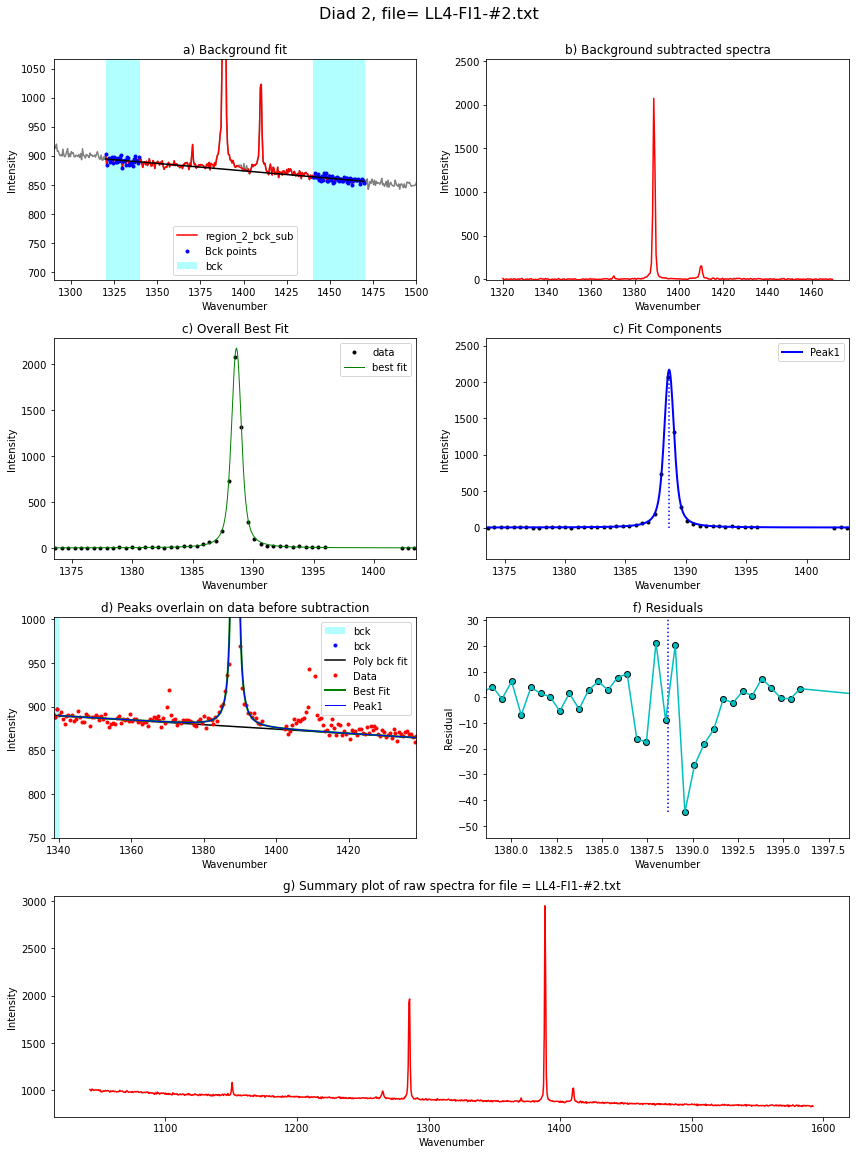

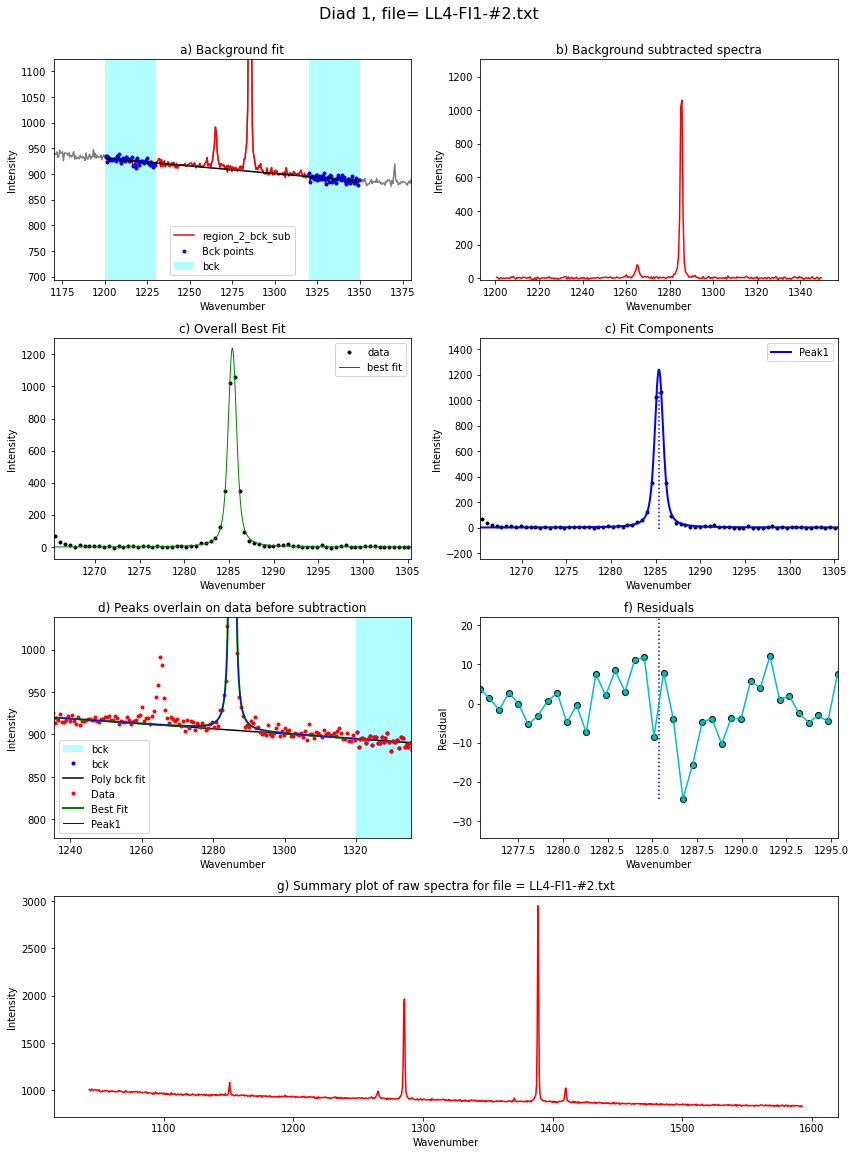

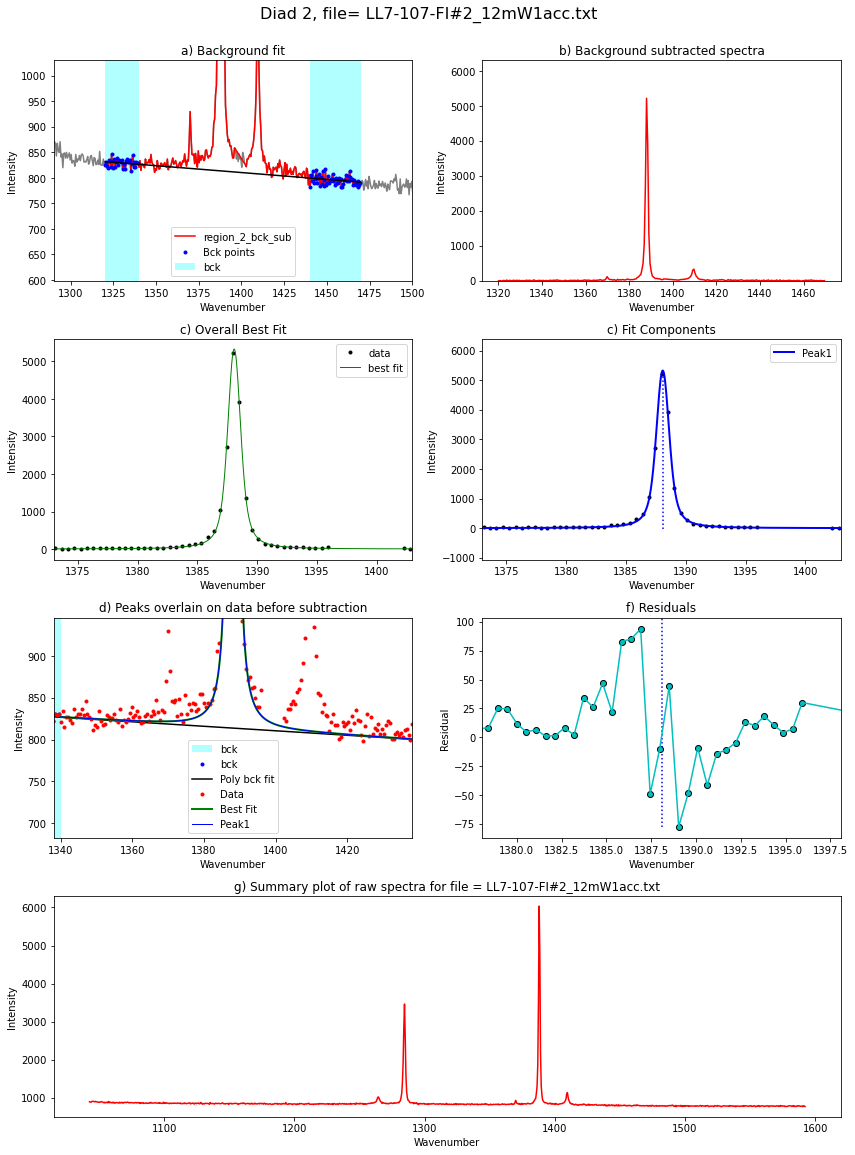

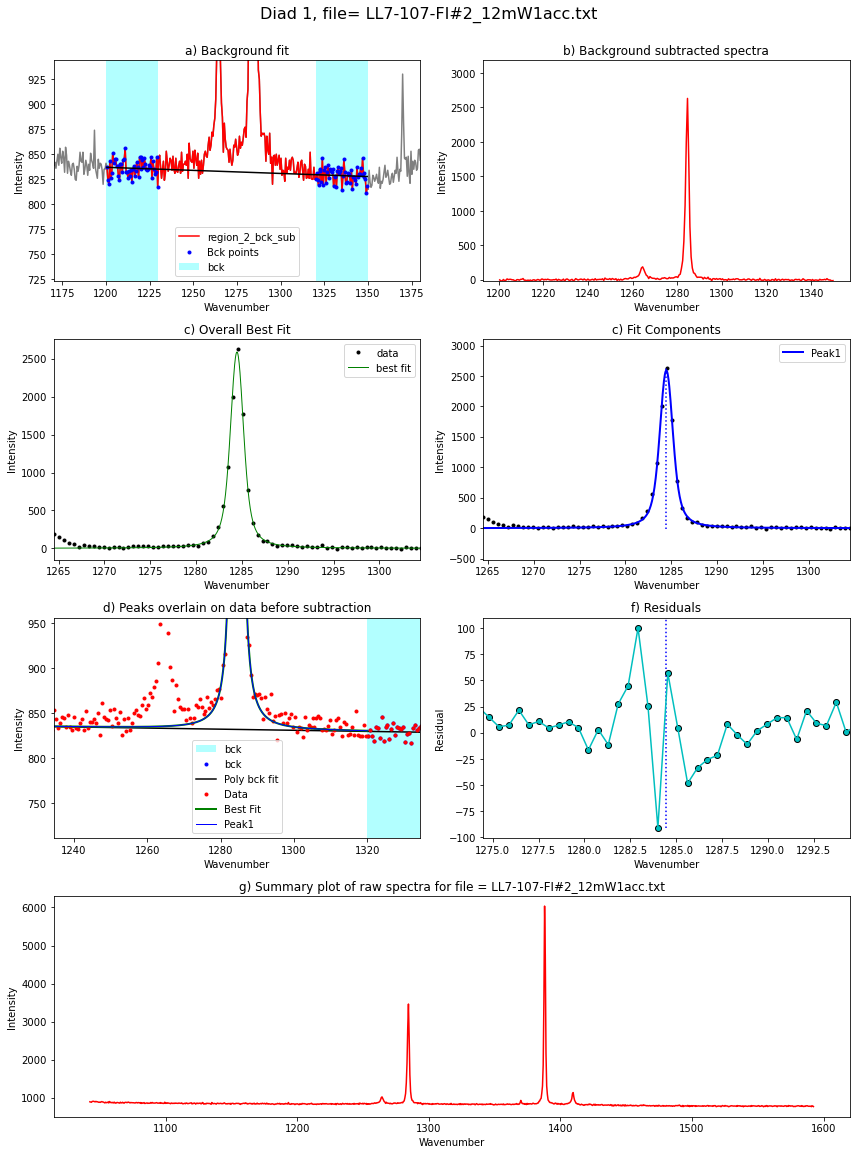

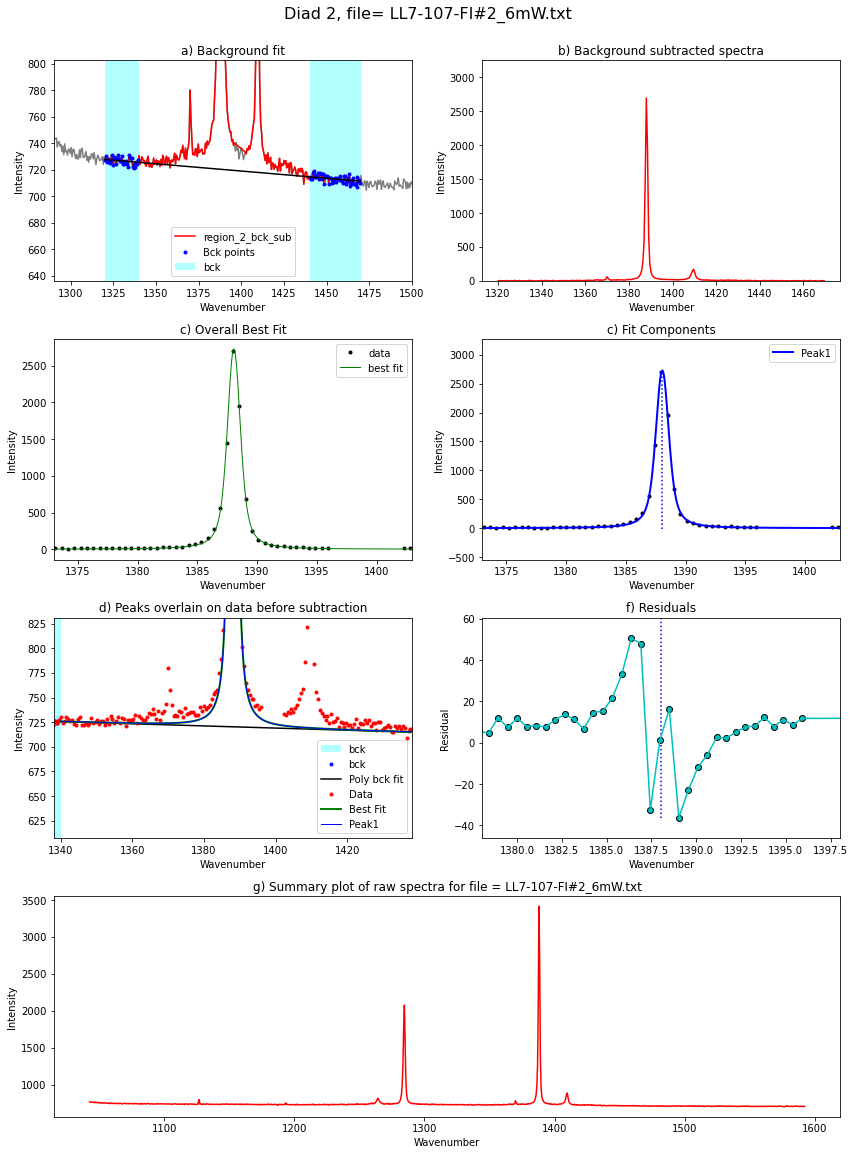

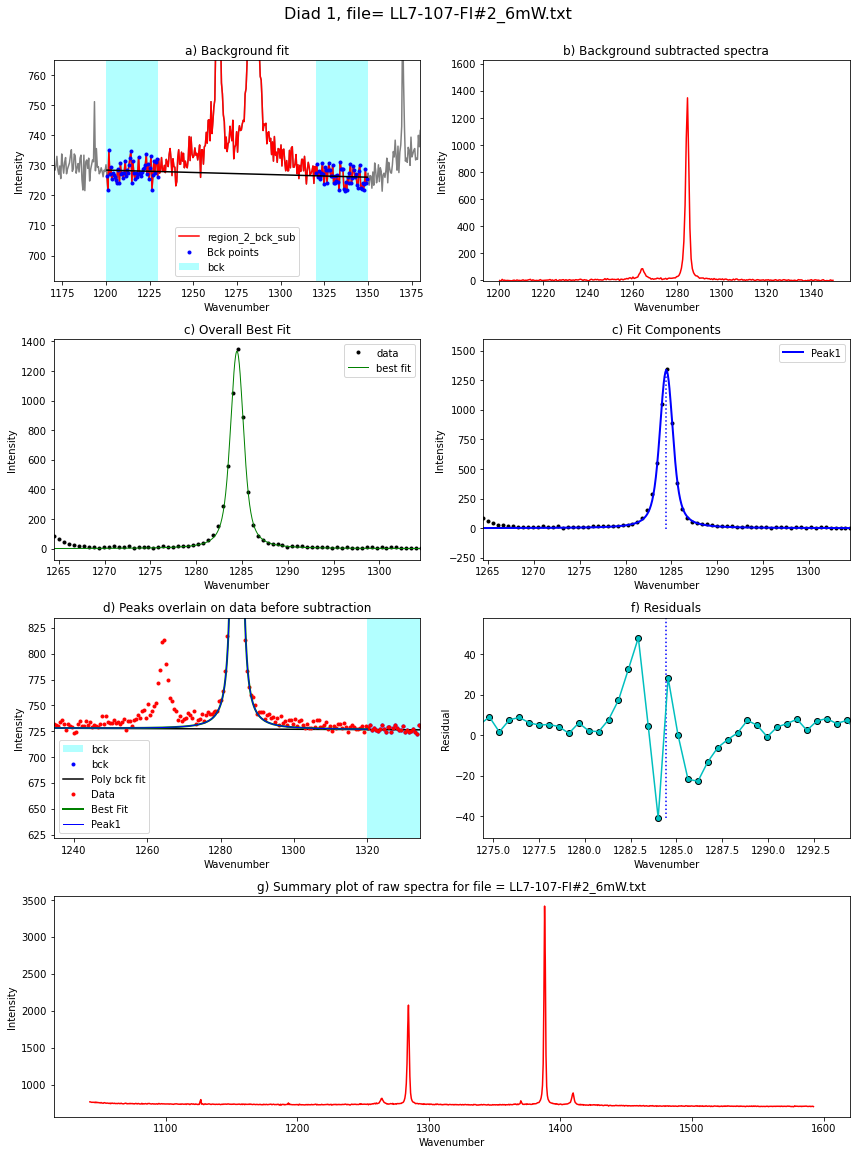

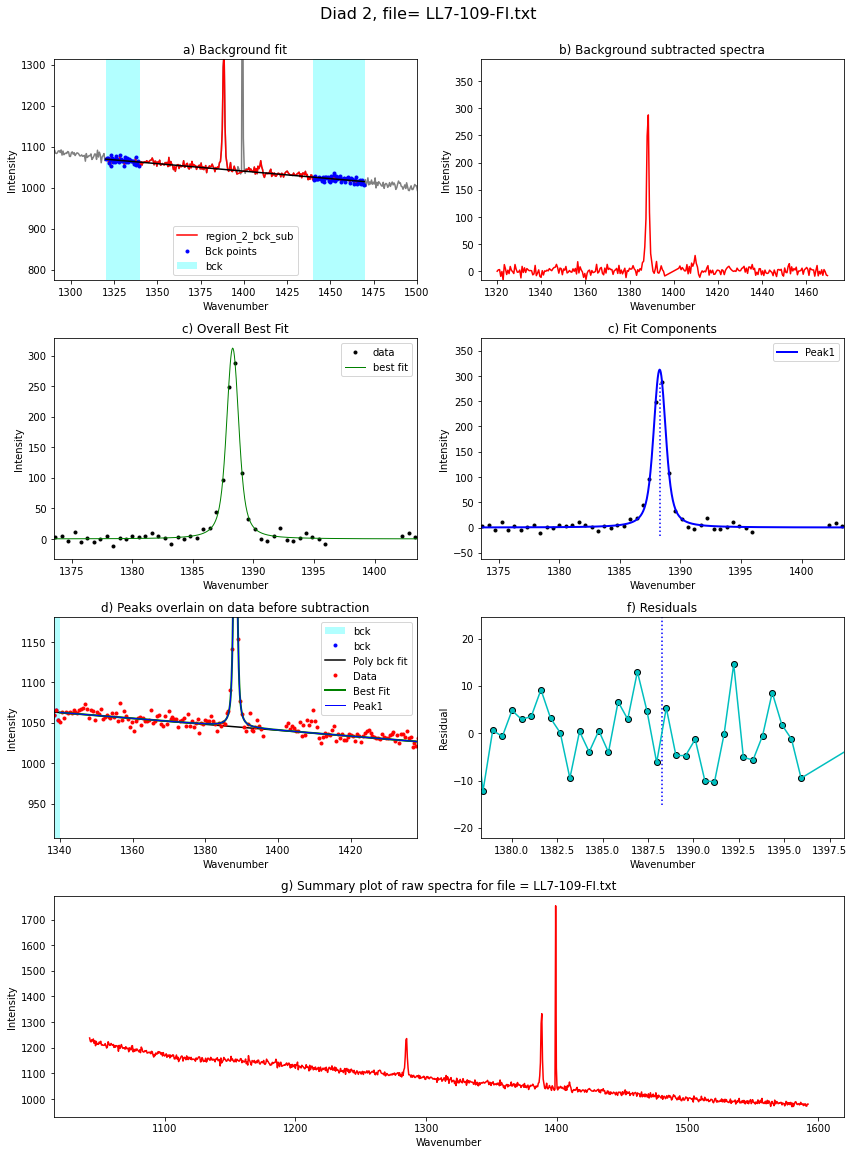

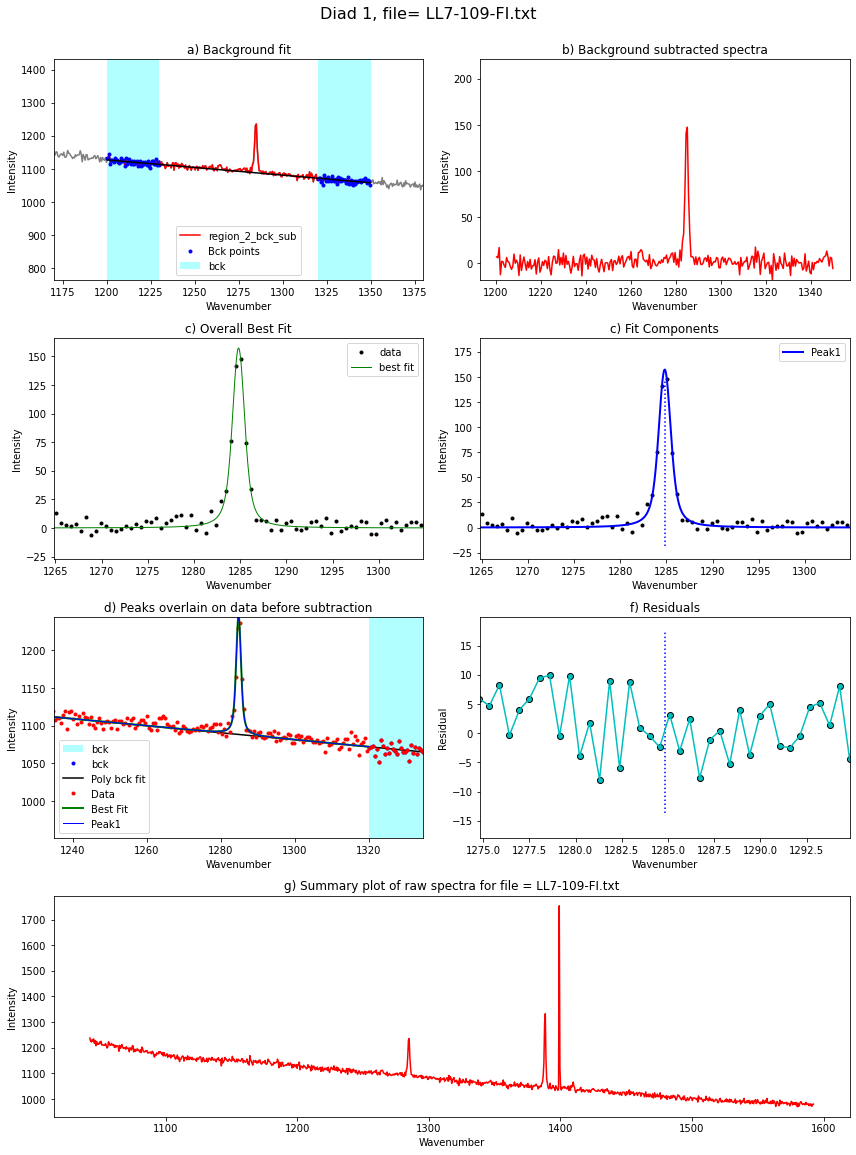

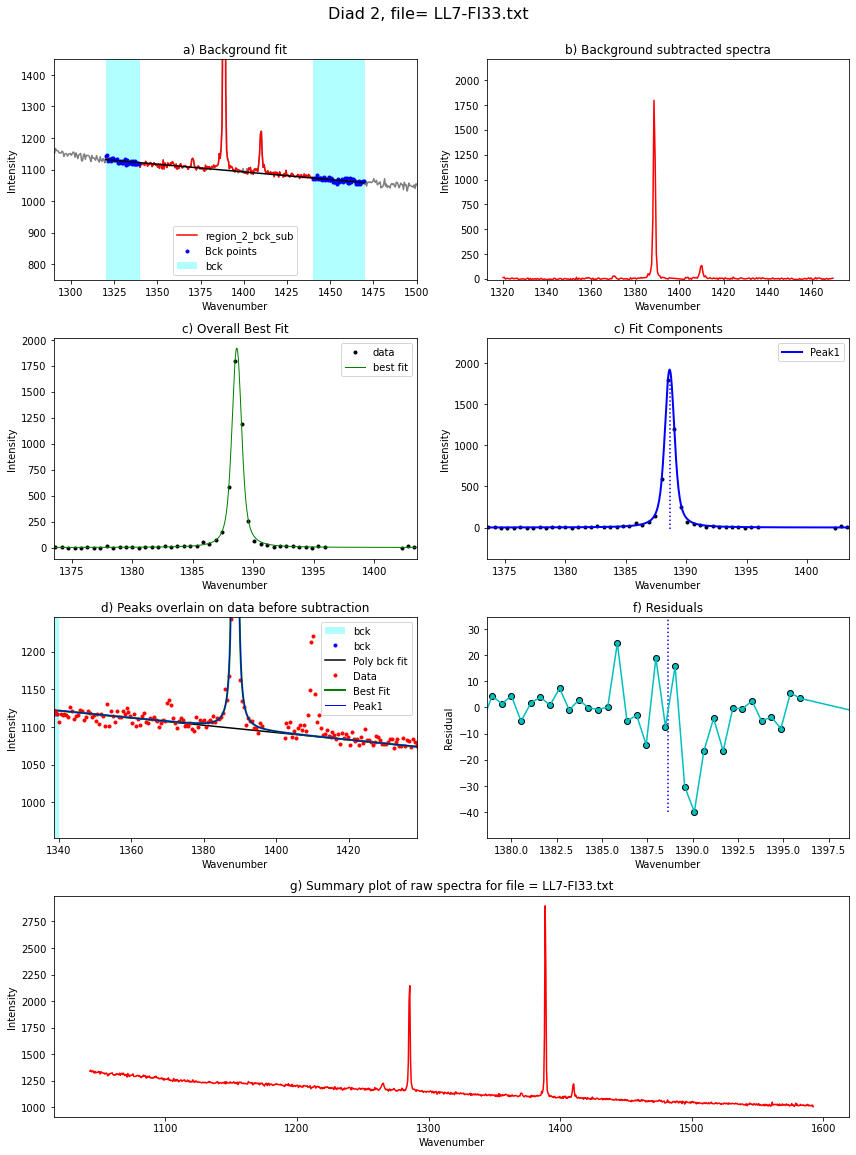

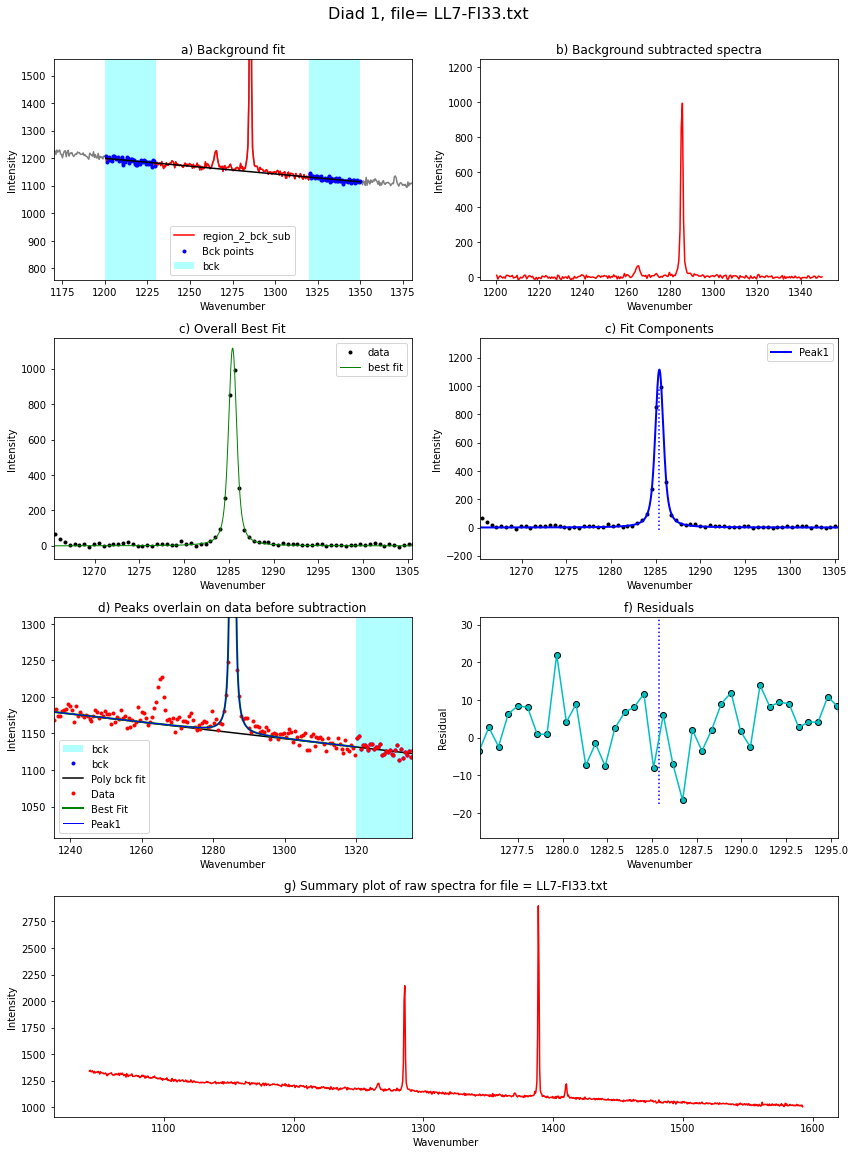

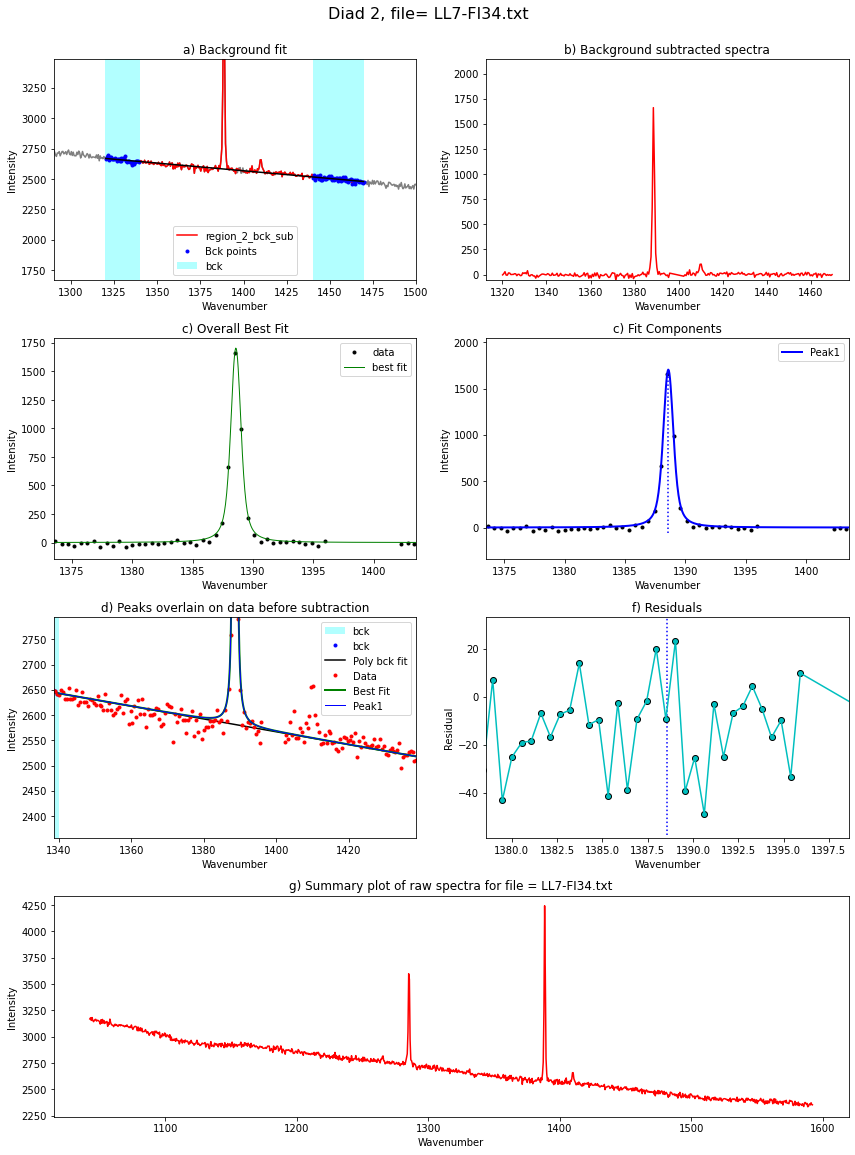

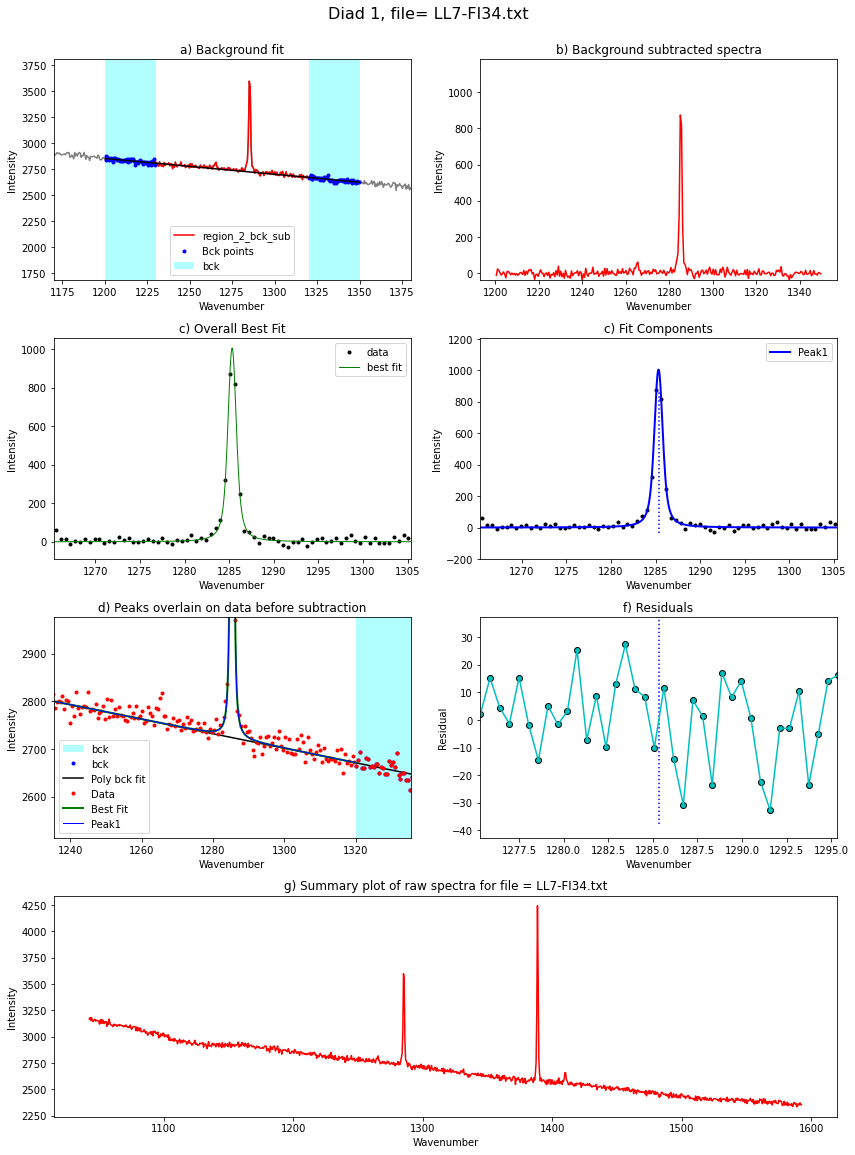

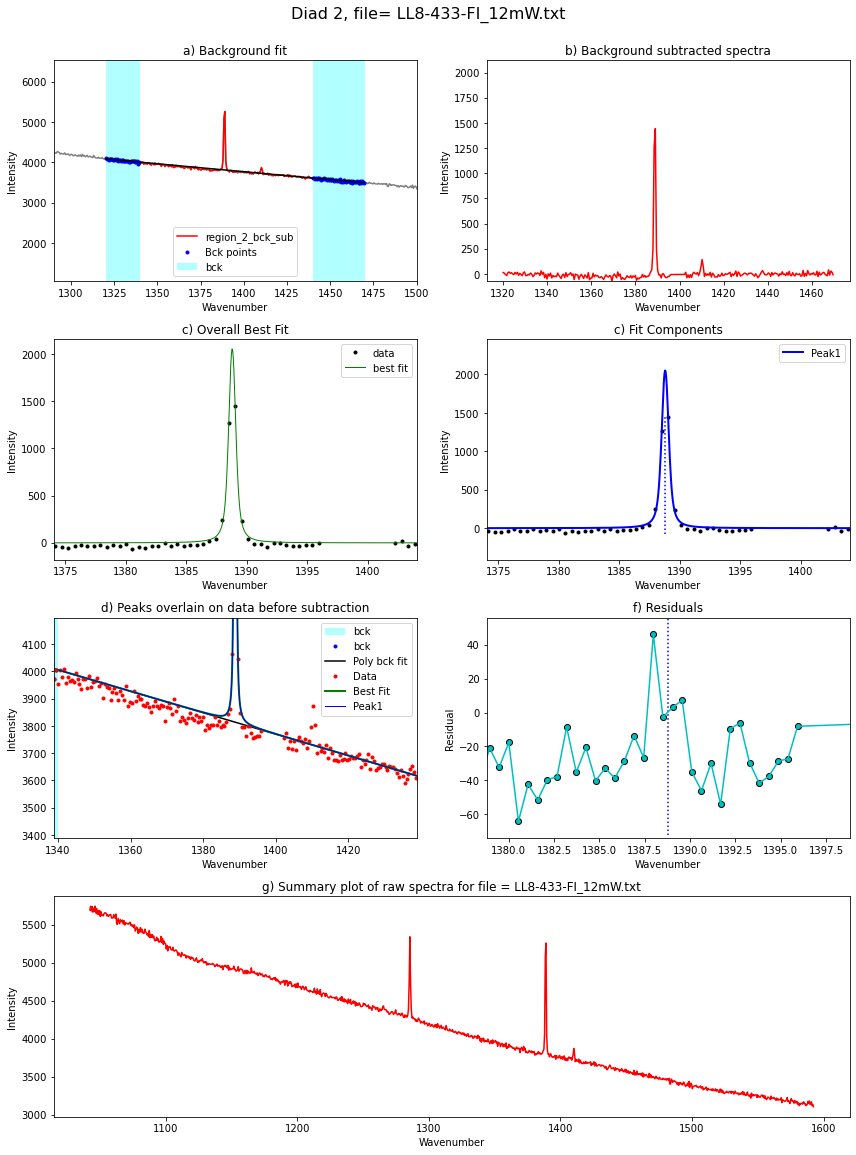

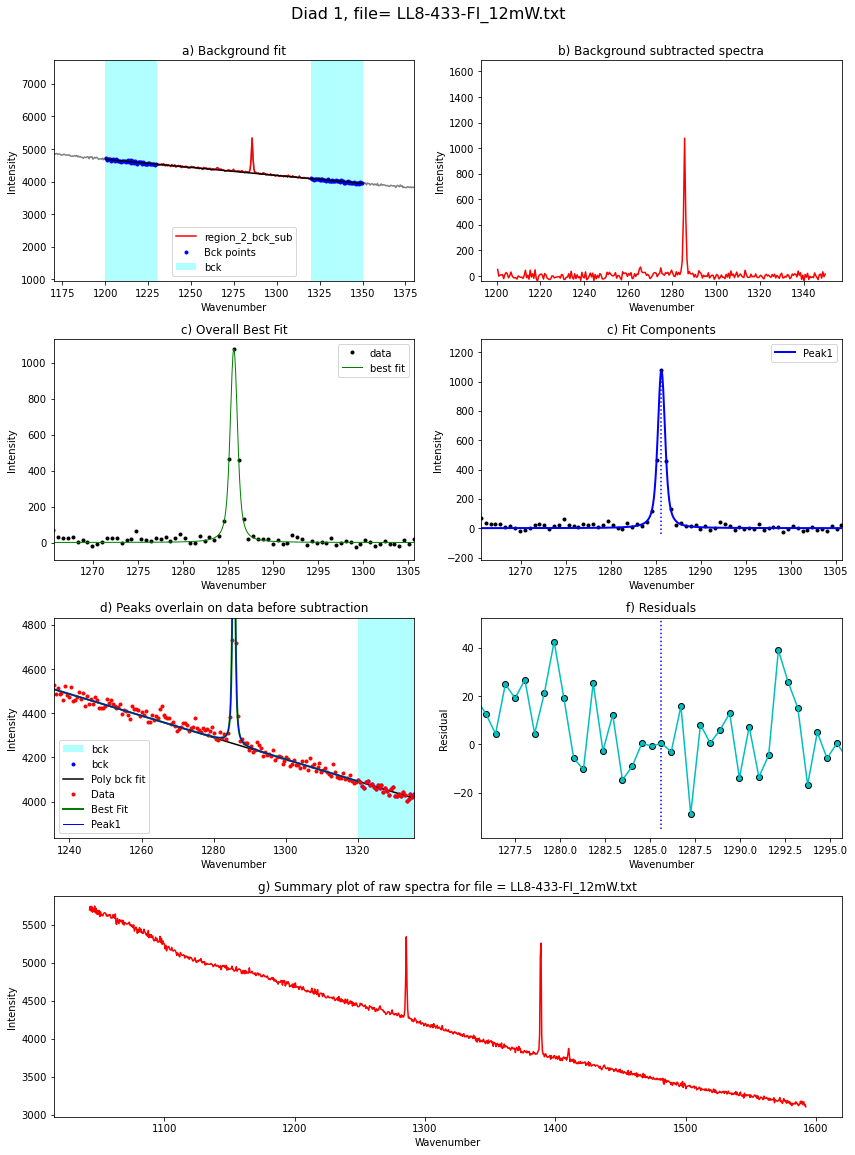

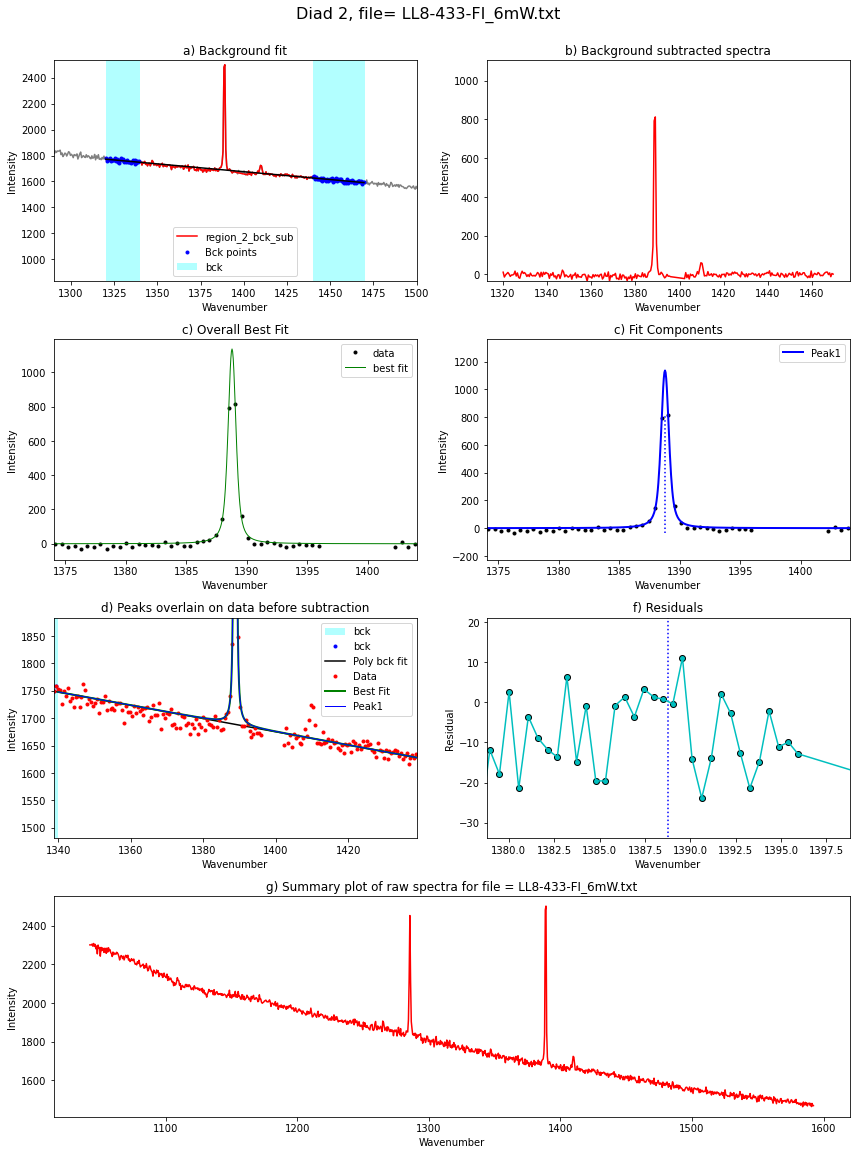

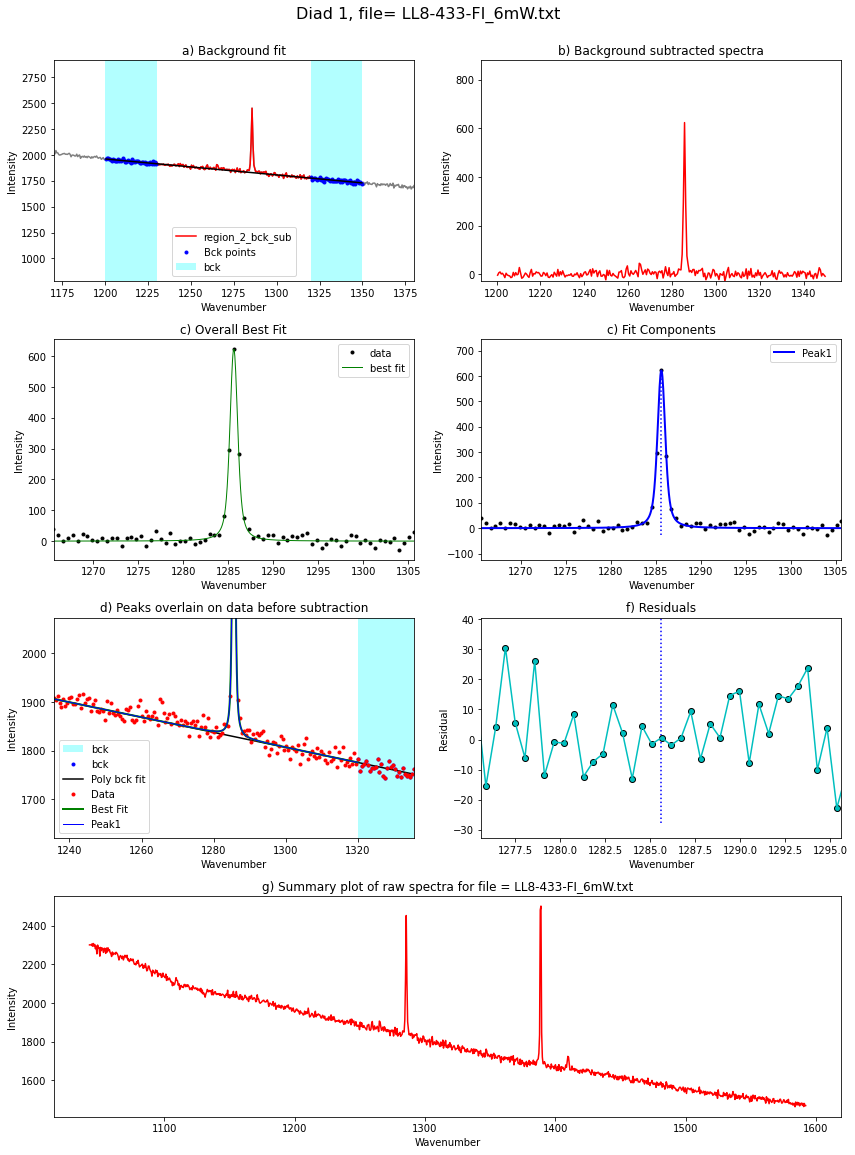

In [76]:
from tqdm import tqdm
plot_figure=True # Means doesnt make figures, lot faster. 
save_excel=True # Saves to excel
save_clipboard=True # Copies to clipboard

df = pd.DataFrame([])
for i in tqdm(range(0, len(Diad_files))):
    
    filename=Diad_files[i]

    
    diad1_peaks, diad2_peaks=pf.identify_diad_peaks(config=diad_id_config,
            path=mypath, filename=filename,
filetype=filetype, n_peaks_diad1=n_peaks_diad1, 
    n_peaks_diad2=n_peaks_diad2, plot_figure=False)

    Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config,
        config2=diad_id_config, peak_pos_voigt=diad2_peaks,
    path=mypath, filename=filename, filetype=filetype)
    
    Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config,
    config2=diad_id_config, peak_pos_voigt=diad1_peaks,
path=mypath, filename=filename, filetype=filetype)
    
    data=pf.combine_diad_outputs(filename=filename, prefix=prefix, 
Diad1_fit=Diad1_fit, path=mypath,
Diad2_fit=Diad2_fit)
 

    df = pd.concat([df, data], axis=0)
df2=df.reset_index(drop=True)

In [77]:
df2

,filename,Splitting,Diad1_Cent,Diad1_Area,Residual_Diad1,Diad2_Cent,Diad2_Area,Residual_Diad2,HB1_Cent,HB1_Area,HB2_Cent,HB2_Area,C13_Cent,C13_Area
0,LL4-FI1-#1,103.256142,1285.318851,361.564267,3.019062,1388.574993,576.462811,3.362005,NaN,0,NaN,0,NaN,0
1,LL4-FI1-#2 (1),103.246828,1285.353549,901.314107,3.238437,1388.600377,1383.741484,4.109046,NaN,0,NaN,0,NaN,0
2,LL4-FI1-#2,103.251463,1285.366755,1854.824672,5.922621,1388.618217,2815.883648,7.822056,NaN,0,NaN,0,NaN,0
3,LL7-107-FI#2_12mW1acc,103.609164,1284.465505,5935.166309,17.638848,1388.074668,9232.452116,22.936143,NaN,0,NaN,0,NaN,0
4,LL7-107-FI#2_6mW,103.606796,1284.448729,3040.393308,8.769625,1388.055525,4764.159309,12.572734,NaN,0,NaN,0,NaN,0
5,LL7-109-FI,103.463792,1284.820331,332.569912,4.711408,1388.284123,498.756837,5.000364,NaN,0,NaN,0,NaN,0
6,LL7-FI33,103.230139,1285.409677,1618.053358,7.932148,1388.639816,2437.160754,8.325121,NaN,0,NaN,0,NaN,0
7,LL7-FI34,103.262234,1285.322032,1516.958522,12.173734,1388.584266,2279.350760,14.352307,NaN,0,NaN,0,NaN,0
8,LL8-433-FI_12mW,103.163471,1285.626001,1386.446213,15.796516,1388.789472,1914.938553,22.835783,NaN,0,NaN,0,NaN,0
9,LL8-433-FI_6mW,103.153645,1285.619767,851.017332,9.878818,1388.773412,1163.906773,9.821167,NaN,0,NaN,0,NaN,0


## Extracting metadata for these diads

In [78]:
meta_path=r"P:\WORK-ACAD\BERKELEY-VIBE\LEILANI-2018-FI\Leilani_2018FI_Oct722\METADATA"
# Find files


# Put the common string you can in all your Ne lines here
ID_str='_'
file_ext_meta='txt' # Will only take files of this type 
exclude_str='Ne' # Will exclude files of this type, sometimes images have same name
prefix=None # Leave as none unless witec appended a number
Ne_files_meta=pf.get_files(path=mypath, file_ext=file_ext, exclude_str='Ne',
                            exclude_str_2='IMG')

Ne_files_meta


exclude type
.png


['LL4-FI1-#1.txt',
 'LL4-FI1-#2 (1).txt',
 'LL4-FI1-#2.txt',
 'LL7-107-FI#1_nodiad.txt',
 'LL7-107-FI#2_12mW1acc.txt',
 'LL7-107-FI#2_6mW.txt',
 'LL7-109-FI.txt',
 'LL7-FI33.txt',
 'LL7-FI34.txt',
 'LL8-245_nodiad.txt',
 'LL8-433-FI_12mW.txt',
 'LL8-433-FI_6mW.txt']

In [79]:
meta=pf.stitch_metadata_in_loop(path=meta_path, Allfiles=Ne_files_meta, prefix=False, trupower=True)

working on fileLL4-FI1-#1.txt
working on fileLL4-FI1-#2 (1).txt
working on fileLL4-FI1-#2.txt
working on fileLL7-107-FI#1_nodiad.txt
working on fileLL7-107-FI#2_12mW1acc.txt
working on fileLL7-107-FI#2_6mW.txt
working on fileLL7-109-FI.txt
working on fileLL7-FI33.txt
working on fileLL7-FI34.txt
working on fileLL8-245_nodiad.txt
working on fileLL8-433-FI_12mW.txt
working on fileLL8-433-FI_6mW.txt
Done


In [80]:
meta

,filename,date,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,index
9,LL8-245_nodiad.txt,"October 7, 2022\n",12.034,45.0,3.0,50.0,"['0h', '2m', '17s']",2:05:54 PM\n,50754.0,1324.987,9
2,LL4-FI1-#2.txt,"October 7, 2022\n",12.035,45.0,5.0,50.0,"['0h', '3m', '46s']",2:15:04 PM\n,51304.0,1324.987,2
1,LL4-FI1-#2 (1).txt,"October 7, 2022\n",6.033,45.0,5.0,50.0,"['0h', '3m', '46s']",2:24:04 PM\n,51844.0,1324.987,1
0,LL4-FI1-#1.txt,"October 7, 2022\n",6.027,45.0,5.0,50.0,"['0h', '3m', '46s']",2:33:50 PM\n,52430.0,1324.987,0
10,LL8-433-FI_12mW.txt,"October 7, 2022\n",11.991,45.0,5.0,50.0,"['0h', '3m', '46s']",3:29:22 PM\n,55762.0,1324.987,10
11,LL8-433-FI_6mW.txt,"October 7, 2022\n",6.030,45.0,5.0,50.0,"['0h', '3m', '47s']",3:38:52 PM\n,56332.0,1324.987,11
3,LL7-107-FI#1_nodiad.txt,"October 7, 2022\n",11.993,45.0,5.0,50.0,"['0h', '3m', '47s']",3:54:03 PM\n,57243.0,1324.987,3
4,LL7-107-FI#2_12mW1acc.txt,"October 7, 2022\n",11.939,45.0,1.0,50.0,"['0h', '1m', '23s']",4:04:48 PM\n,57888.0,1324.987,4
5,LL7-107-FI#2_6mW.txt,"October 7, 2022\n",6.029,45.0,5.0,50.0,"['0h', '3m', '46s']",4:06:15 PM\n,57975.0,1324.987,5
6,LL7-109-FI.txt,"October 7, 2022\n",5.999,45.0,5.0,50.0,"['0h', '3m', '47s']",4:22:46 PM\n,58966.0,1324.987,6


## Stitching metadata and data together

In [81]:
meta['filename'][0]

'LL4-FI1-#1.txt'

In [82]:
df2['filename'][0]

'LL4-FI1-#1'

In [83]:
# remove these to get the pure file name you can compare 
file_m=pf.extracting_filenames_generic(names=meta['filename'],
    prefix=False, 
    suffix=False, 
   file_type='.txt')

file_m

array(['LL8-245_nodiad', 'LL4-FI1-#2', 'LL4-FI1-#2 (1)', 'LL4-FI1-#1',
       'LL8-433-FI_12mW', 'LL8-433-FI_6mW', 'LL7-107-FI#1_nodiad',
       'LL7-107-FI#2_12mW1acc', 'LL7-107-FI#2_6mW', 'LL7-109-FI',
       'LL7-FI34', 'LL7-FI33'], dtype=object)

In [84]:
# Remove these to get the pure file name
file_s=pf.extracting_filenames_generic(names=df2['filename'],
    prefix=False,
   file_type='.txt')
file_s

array(['LL4-FI1-#1', 'LL4-FI1-#2 (1)', 'LL4-FI1-#2',
       'LL7-107-FI#2_12mW1acc', 'LL7-107-FI#2_6mW', 'LL7-109-FI',
       'LL7-FI33', 'LL7-FI34', 'LL8-433-FI_12mW', 'LL8-433-FI_6mW'],
      dtype=object)

In [85]:
# Combining them together
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

In [86]:
df_combo.head()

,filename_x,Splitting,Diad1_Cent,Diad1_Area,Residual_Diad1,Diad2_Cent,Diad2_Area,Residual_Diad2,HB1_Cent,HB1_Area,...,date,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,index
0,LL4-FI1-#1,103.256142,1285.318851,361.564267,3.019062,1388.574993,576.462811,3.362005,NaN,0,...,"October 7, 2022\n",6.027,45.0,5.0,50.0,"['0h', '3m', '46s']",2:33:50 PM\n,52430.0,1324.987,0
1,LL4-FI1-#2 (1),103.246828,1285.353549,901.314107,3.238437,1388.600377,1383.741484,4.109046,NaN,0,...,"October 7, 2022\n",6.033,45.0,5.0,50.0,"['0h', '3m', '46s']",2:24:04 PM\n,51844.0,1324.987,1
2,LL4-FI1-#2,103.251463,1285.366755,1854.824672,5.922621,1388.618217,2815.883648,7.822056,NaN,0,...,"October 7, 2022\n",12.035,45.0,5.0,50.0,"['0h', '3m', '46s']",2:15:04 PM\n,51304.0,1324.987,2
3,LL7-107-FI#2_12mW1acc,103.609164,1284.465505,5935.166309,17.638848,1388.074668,9232.452116,22.936143,NaN,0,...,"October 7, 2022\n",11.939,45.0,1.0,50.0,"['0h', '1m', '23s']",4:04:48 PM\n,57888.0,1324.987,4
4,LL7-107-FI#2_6mW,103.606796,1284.448729,3040.393308,8.769625,1388.055525,4764.159309,12.572734,NaN,0,...,"October 7, 2022\n",6.029,45.0,5.0,50.0,"['0h', '3m', '46s']",4:06:15 PM\n,57975.0,1324.987,5


## Now load in the model for doing the Ne fitting

In [87]:
from pickle import load
import pickle

pickle_path="P:\WORK-ACAD\BERKELEY-VIBE\LEILANI-2018-FI\FIT_OUTPUT\Pickles"
file_pkl=pickle_path + '/' + 'Ne_Line_Regression_Leilani18-100722.pck'
with open(file_pkl, 'rb') as file_handle:
    my_loaded_model = pickle.load(file_handle)

In [88]:
df_combo['Ne_Correction']=my_loaded_model(df_combo['sec since midnight'])
df_combo['Corrected_Splitting']=df_combo['Ne_Correction']*df_combo['Splitting']
df_combo

,filename_x,Splitting,Diad1_Cent,Diad1_Area,Residual_Diad1,Diad2_Cent,Diad2_Area,Residual_Diad2,HB1_Cent,HB1_Area,...,Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,index,Ne_Correction,Corrected_Splitting
0,LL4-FI1-#1,103.256142,1285.318851,361.564267,3.019062,1388.574993,576.462811,3.362005,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '46s']",2:33:50 PM\n,52430.0,1324.987,0,0.998293,103.079889
1,LL4-FI1-#2 (1),103.246828,1285.353549,901.314107,3.238437,1388.600377,1383.741484,4.109046,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '46s']",2:24:04 PM\n,51844.0,1324.987,1,0.998295,103.070761
2,LL4-FI1-#2,103.251463,1285.366755,1854.824672,5.922621,1388.618217,2815.883648,7.822056,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '46s']",2:15:04 PM\n,51304.0,1324.987,2,0.998296,103.075545
3,LL7-107-FI#2_12mW1acc,103.609164,1284.465505,5935.166309,17.638848,1388.074668,9232.452116,22.936143,NaN,0,...,45.0,1.0,50.0,"['0h', '1m', '23s']",4:04:48 PM\n,57888.0,1324.987,4,0.998278,103.430712
4,LL7-107-FI#2_6mW,103.606796,1284.448729,3040.393308,8.769625,1388.055525,4764.159309,12.572734,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '46s']",4:06:15 PM\n,57975.0,1324.987,5,0.998277,103.428323
5,LL7-109-FI,103.463792,1284.820331,332.569912,4.711408,1388.284123,498.756837,5.000364,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '47s']",4:22:46 PM\n,58966.0,1324.987,6,0.998275,103.285277
6,LL7-FI33,103.230139,1285.409677,1618.053358,7.932148,1388.639816,2437.160754,8.325121,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '46s']",4:51:48 PM\n,60708.0,1324.987,7,0.998270,103.051520
7,LL7-FI34,103.262234,1285.322032,1516.958522,12.173734,1388.584266,2279.350760,14.352307,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '47s']",4:38:57 PM\n,59937.0,1324.987,8,0.998272,103.083783
8,LL8-433-FI_12mW,103.163471,1285.626001,1386.446213,15.796516,1388.789472,1914.938553,22.835783,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '46s']",3:29:22 PM\n,55762.0,1324.987,10,0.998284,102.986406
9,LL8-433-FI_6mW,103.153645,1285.619767,851.017332,9.878818,1388.773412,1163.906773,9.821167,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '47s']",3:38:52 PM\n,56332.0,1324.987,11,0.998282,102.976431


In [89]:
df_combo_filt=df2.loc[(df2['Diad1_Area']>10)]
df_combo_filt=df_combo[df_combo['Diad1_Area']>10]
df_combo_filt

,filename_x,Splitting,Diad1_Cent,Diad1_Area,Residual_Diad1,Diad2_Cent,Diad2_Area,Residual_Diad2,HB1_Cent,HB1_Area,...,Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,index,Ne_Correction,Corrected_Splitting
0,LL4-FI1-#1,103.256142,1285.318851,361.564267,3.019062,1388.574993,576.462811,3.362005,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '46s']",2:33:50 PM\n,52430.0,1324.987,0,0.998293,103.079889
1,LL4-FI1-#2 (1),103.246828,1285.353549,901.314107,3.238437,1388.600377,1383.741484,4.109046,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '46s']",2:24:04 PM\n,51844.0,1324.987,1,0.998295,103.070761
2,LL4-FI1-#2,103.251463,1285.366755,1854.824672,5.922621,1388.618217,2815.883648,7.822056,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '46s']",2:15:04 PM\n,51304.0,1324.987,2,0.998296,103.075545
3,LL7-107-FI#2_12mW1acc,103.609164,1284.465505,5935.166309,17.638848,1388.074668,9232.452116,22.936143,NaN,0,...,45.0,1.0,50.0,"['0h', '1m', '23s']",4:04:48 PM\n,57888.0,1324.987,4,0.998278,103.430712
4,LL7-107-FI#2_6mW,103.606796,1284.448729,3040.393308,8.769625,1388.055525,4764.159309,12.572734,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '46s']",4:06:15 PM\n,57975.0,1324.987,5,0.998277,103.428323
5,LL7-109-FI,103.463792,1284.820331,332.569912,4.711408,1388.284123,498.756837,5.000364,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '47s']",4:22:46 PM\n,58966.0,1324.987,6,0.998275,103.285277
6,LL7-FI33,103.230139,1285.409677,1618.053358,7.932148,1388.639816,2437.160754,8.325121,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '46s']",4:51:48 PM\n,60708.0,1324.987,7,0.998270,103.051520
7,LL7-FI34,103.262234,1285.322032,1516.958522,12.173734,1388.584266,2279.350760,14.352307,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '47s']",4:38:57 PM\n,59937.0,1324.987,8,0.998272,103.083783
8,LL8-433-FI_12mW,103.163471,1285.626001,1386.446213,15.796516,1388.789472,1914.938553,22.835783,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '46s']",3:29:22 PM\n,55762.0,1324.987,10,0.998284,102.986406
9,LL8-433-FI_6mW,103.153645,1285.619767,851.017332,9.878818,1388.773412,1163.906773,9.821167,NaN,0,...,45.0,5.0,50.0,"['0h', '3m', '47s']",3:38:52 PM\n,56332.0,1324.987,11,0.998282,102.976431


In [90]:
df_combo_filt.to_excel(r"P:\WORK-ACAD\BERKELEY-VIBE\LEILANI-2018-FI\FIT_OUTPUT\Leilani18-FI_100722_LD.xlsx")

In [91]:
densities=pf.calculate_density_cornell(temp='SupCrit', Split=df_combo['Corrected_Splitting'])
densities.head()

,Preferred D,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Splitting,Preferred_D
0,0.135260,Y,"SupCrit, low density",0.129062,-0.171399,0.135260,0.135844,-0.143124,SupCrit,103.079889,NaN
1,0.131827,Y,"SupCrit, low density",0.125655,-0.179310,0.131827,0.132320,-0.151029,SupCrit,103.070761,NaN
2,0.133626,Y,"SupCrit, low density",0.127441,-0.175161,0.133626,0.134165,-0.146883,SupCrit,103.075545,NaN
3,0.279843,Y,"SupCrit, Med density",0.260010,0.114207,0.267184,0.279843,0.141541,SupCrit,103.430712,NaN
4,0.278812,Y,"SupCrit, Med density",0.259118,0.112384,0.266286,0.278812,0.139728,SupCrit,103.428323,NaN


In [57]:
import statistics as sta
sd=sta.stdev(densities['Preferred D'][[0,1,2]])
meanrho=np.mean(densities['Preferred D'][[0,1,2]])

print('density-postcalibration:'+str("{:.3f}".format(meanrho))+u"\u00B1"+str("{:.3f}".format(sd))+' g/mL')

density-postcalibration:0.277±0.001 g/mL


In [60]:
sd_split=sta.stdev(densities['Splitting'][[0,1,2]])
meansplit=np.mean(densities['Splitting'][[0,1,2]])

print('corrected split-postcalibration:'+str("{:.3f}".format(meansplit))+u"\u00B1"+str("{:.3f}".format(sd_split))+' cm-1')

corrected split-postcalibration:103.423±0.001 cm-1


In [42]:
meanrho

0.2683418320114315